<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tommykamaz/faces-dataset-small")

print("Path to dataset files:", path)

100%|██████████| 3.99G/3.99G [03:07<00:00, 22.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tommykamaz/faces-dataset-small/versions/1


Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [4]:
from torchvision import datasets
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    :param image_size: height and width of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """
    # Transformation pipeline: resize, convert to tensor, and normalize
    transform = tt.Compose([
        tt.Resize((image_size, image_size)),  # Resize to the given size
        tt.ToTensor(),                        # Convert images to PyTorch tensors
        tt.Normalize(mean=[0.5], std=[0.5])   # Normalize pixel values to [-1, 1]
    ])

    # Load dataset from the path defined globally
    dataset = datasets.ImageFolder(root=path, transform=transform)

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    return dataloader

In [5]:
image_size = 128
batch_size = 32

# Определение устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Построение DataLoader
dataloader = get_dataloader(image_size, batch_size)

# Перенос данных на устройство
for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)  # Перенос данных
    print(f"Batch shape: {images.shape}, Device: {images.device}")
    break  # Для проверки выводим только одну итерацию


#TODO: build dataloader and transfer it to device

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch shape: torch.Size([32, 3, 128, 128]), Device: cuda:0


## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [110]:
latent_size = 128

In [111]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)


In [112]:
import torch.nn as nn

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)


In [113]:
# Переносим модели на устройство
generator = generator.to(device)
discriminator = discriminator.to(device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [88]:
import torch.optim as optim
import torch.nn as nn

In [117]:
lr = 0.0001
epochs = 30

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [118]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()  # Переводим дискриминатор в режим обучения
    model["generator"].train()  # Переводим генератор в режим обучения
    torch.cuda.empty_cache()  # Очищаем кеш GPU

    # Инициализация списков для потерь и оценок
    losses_g = []  # Потери для генератора
    losses_d = []  # Потери для дискриминатора
    real_scores = []  # Оценки реальных изображений
    fake_scores = []  # Оценки фальшивых изображений

    # Создание оптимизаторов для дискриминатора и генератора
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []  # Потери для дискриминатора за эпоху
        loss_g_per_epoch = []  # Потери для генератора за эпоху
        real_score_per_epoch = []  # Оценки реальных изображений за эпоху
        fake_score_per_epoch = []  # Оценки фальшивых изображений за эпоху
        for real_images, _ in tqdm(dataloader):  # Проходим по всем изображениям из dataloader
            # Переносим реальные изображения на устройство (GPU)
            real_images = real_images.to(device)

            # Обучение дискриминатора
            # Обнуляем градиенты дискриминатора
            optimizer["discriminator"].zero_grad()

            # Пропускаем реальные изображения через дискриминатор
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)  # Цели для реальных изображений
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()  # Оценка реальных изображений

            # Генерация фальшивых изображений
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Случайный латентный вектор
            fake_images = model["generator"](latent)  # Генерация фальшивых изображений

            # Пропускаем фальшивые изображения через дискриминатор
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)  # Цели для фальшивых изображений
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()  # Оценка фальшивых изображений

            # Записываем оценки для текущей эпохи
            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Обновляем веса дискриминатора
            loss_d = real_loss + fake_loss  # Общие потери дискриминатора
            loss_d.backward()  # Вычисление градиентов
            optimizer["discriminator"].step()  # Обновление весов
            loss_d_per_epoch.append(loss_d.item())  # Записываем потери за эпоху

            # Обучение генератора
            # Обнуляем градиенты генератора
            optimizer["generator"].zero_grad()

            # Генерация фальшивых изображений
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Пытаемся обмануть дискриминатор
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)  # Цели для фальшивых изображений (пытаться сделать их реальными)
            loss_g = criterion["generator"](preds, targets)

            # Обновляем веса генератора
            loss_g.backward()  # Вычисление градиентов
            optimizer["generator"].step()  # Обновление весов
            loss_g_per_epoch.append(loss_g.item())  # Записываем потери за эпоху

        # Записываем средние потери и оценки за эпоху
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Логирование потерь и оценок (для последней партии)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

    return losses_g, losses_d, real_scores, fake_scores

In [119]:
history = fit(model, criterion, epochs, lr)

100%|██████████| 99/99 [02:15<00:00,  1.37s/it]


Epoch [1/30], loss_g: 11.0056, loss_d: 0.1618, real_score: 0.9565, fake_score: 0.0654


100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Epoch [2/30], loss_g: 9.0832, loss_d: 0.0407, real_score: 0.9828, fake_score: 0.0195


100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Epoch [3/30], loss_g: 7.3856, loss_d: 0.0122, real_score: 0.9932, fake_score: 0.0051


100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Epoch [4/30], loss_g: 7.6351, loss_d: 0.0055, real_score: 0.9970, fake_score: 0.0024


100%|██████████| 99/99 [02:09<00:00,  1.30s/it]


Epoch [5/30], loss_g: 7.3804, loss_d: 0.0035, real_score: 0.9982, fake_score: 0.0017


100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Epoch [6/30], loss_g: 7.7772, loss_d: 0.0024, real_score: 0.9987, fake_score: 0.0011


100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Epoch [7/30], loss_g: 8.4490, loss_d: 0.0020, real_score: 0.9990, fake_score: 0.0009


100%|██████████| 99/99 [02:11<00:00,  1.33s/it]


Epoch [8/30], loss_g: 7.8145, loss_d: 0.0010, real_score: 0.9996, fake_score: 0.0006


100%|██████████| 99/99 [02:09<00:00,  1.31s/it]


Epoch [9/30], loss_g: 8.1789, loss_d: 0.0009, real_score: 0.9996, fake_score: 0.0005


100%|██████████| 99/99 [02:09<00:00,  1.31s/it]


Epoch [10/30], loss_g: 8.7683, loss_d: 0.0013, real_score: 0.9992, fake_score: 0.0005


100%|██████████| 99/99 [02:06<00:00,  1.27s/it]


Epoch [11/30], loss_g: 9.4364, loss_d: 0.5321, real_score: 0.9157, fake_score: 0.0776


100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Epoch [12/30], loss_g: 7.2536, loss_d: 0.1564, real_score: 0.9571, fake_score: 0.0365


100%|██████████| 99/99 [02:09<00:00,  1.30s/it]


Epoch [13/30], loss_g: 7.2828, loss_d: 0.0119, real_score: 0.9943, fake_score: 0.0060


100%|██████████| 99/99 [02:09<00:00,  1.31s/it]


Epoch [14/30], loss_g: 6.8564, loss_d: 0.0056, real_score: 0.9975, fake_score: 0.0030


100%|██████████| 99/99 [02:09<00:00,  1.31s/it]


Epoch [15/30], loss_g: 7.6976, loss_d: 0.5032, real_score: 0.9387, fake_score: 0.0477


100%|██████████| 99/99 [02:09<00:00,  1.31s/it]


Epoch [16/30], loss_g: 5.8045, loss_d: 0.0308, real_score: 0.9853, fake_score: 0.0139


100%|██████████| 99/99 [02:10<00:00,  1.32s/it]


Epoch [17/30], loss_g: 6.1910, loss_d: 0.0105, real_score: 0.9949, fake_score: 0.0047


100%|██████████| 99/99 [02:10<00:00,  1.32s/it]


Epoch [18/30], loss_g: 6.4148, loss_d: 0.5013, real_score: 0.9188, fake_score: 0.0714


100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Epoch [19/30], loss_g: 4.5491, loss_d: 0.2325, real_score: 0.9353, fake_score: 0.0614


100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Epoch [20/30], loss_g: 5.1354, loss_d: 0.3199, real_score: 0.9166, fake_score: 0.0836


100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Epoch [21/30], loss_g: 5.3301, loss_d: 0.4147, real_score: 0.8839, fake_score: 0.1148


100%|██████████| 99/99 [02:09<00:00,  1.31s/it]


Epoch [22/30], loss_g: 5.7230, loss_d: 0.4281, real_score: 0.8897, fake_score: 0.1143


100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Epoch [23/30], loss_g: 5.6251, loss_d: 0.3373, real_score: 0.9030, fake_score: 0.1008


100%|██████████| 99/99 [02:03<00:00,  1.25s/it]


Epoch [24/30], loss_g: 6.2825, loss_d: 0.2674, real_score: 0.9211, fake_score: 0.0819


100%|██████████| 99/99 [02:09<00:00,  1.30s/it]


Epoch [25/30], loss_g: 6.0147, loss_d: 0.4145, real_score: 0.8858, fake_score: 0.1146


100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Epoch [26/30], loss_g: 5.2961, loss_d: 0.4177, real_score: 0.8785, fake_score: 0.1233


100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Epoch [27/30], loss_g: 5.6310, loss_d: 0.4929, real_score: 0.8698, fake_score: 0.1339


100%|██████████| 99/99 [02:09<00:00,  1.31s/it]


Epoch [28/30], loss_g: 5.4385, loss_d: 0.4008, real_score: 0.8800, fake_score: 0.1125


100%|██████████| 99/99 [02:09<00:00,  1.31s/it]


Epoch [29/30], loss_g: 6.0939, loss_d: 0.3846, real_score: 0.8808, fake_score: 0.1174


100%|██████████| 99/99 [02:08<00:00,  1.29s/it]

Epoch [30/30], loss_g: 6.0283, loss_d: 0.3868, real_score: 0.8835, fake_score: 0.1197


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

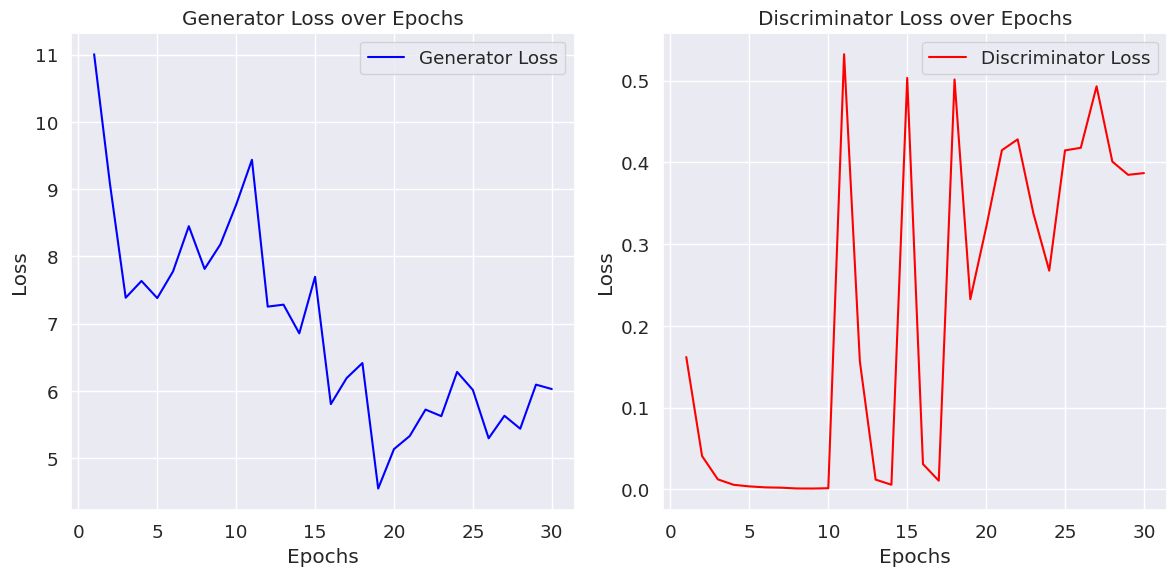

In [120]:
import matplotlib.pyplot as plt

# Предполагаем, что history содержит данные: losses_g, losses_d, real_scores, fake_scores
losses_g, losses_d, real_scores, fake_scores = history

# Построение графиков
plt.figure(figsize=(12, 6))

# График лосса генератора
plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses_g) + 1), losses_g, label="Generator Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator Loss over Epochs")
plt.legend()

# График лосса дискриминатора
plt.subplot(1, 2, 2)
plt.plot(range(1, len(losses_d) + 1), losses_d, label="Discriminator Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator Loss over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


В первые эпохи потери генератора снижаются, но начиная с 8-й эпохи, лосс становится неустойчивым, колеблясь в пределах 5-7. Дискриминатор быстро обучается, и его лосс падает почти до нуля, но с 10-й эпохи начинают возникать сильные колебания. Это указывает на нестабильность в процессе обучения, где дискриминатор может быть слишком сильным по сравнению с генератором. Требуется настройка гиперпараметров для стабилизации модели.

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [121]:
import matplotlib.pyplot as plt

def show_images(generated):
    # Составляем сетку из изображений
    n_images = generated.size(0)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 3, 3))

    # Если одно изображение, то axes не будет списком, поэтому делаем его списком
    if n_images == 1:
        axes = [axes]

    # Проходим по всем изображениям и отображаем их
    for i, ax in enumerate(axes):
        # Переводим тензор в формат изображения (обратная нормализация и перестановка)
        img = generated[i].cpu().detach().numpy().transpose(1, 2, 0)
        img = (img + 1) / 2  # Переводим пиксели в диапазон [0, 1]

        ax.imshow(img)
        ax.axis('off')

    plt.show()

In [122]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

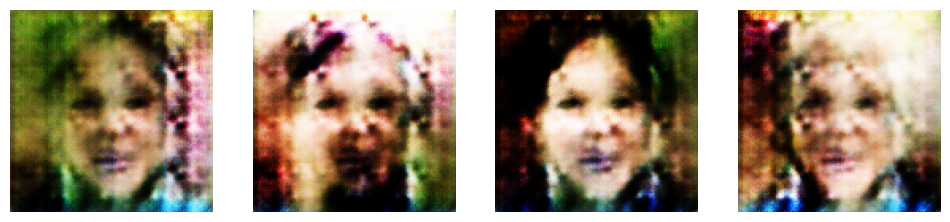

In [123]:
show_images(fake_images)

Как вам качество получившихся изображений?

Отличные изображения для фильмов ужаса)

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [124]:
n_real_images = 64  # Число реальных изображений

# Получение реальных изображений из датасета
real_images, _ = next(iter(dataloader))  # Извлекаем первую партию из dataloader
real_images = real_images[:n_real_images].to(device)  # Ограничиваем размер и переносим на устройство

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [127]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
import torch

# 1. Генерация фейковых изображений
def generate_fake_images(n_images, latent_size, model, device):
    # Генерация латентных векторов
    fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)

    # Генерация фейковых изображений с использованием генератора
    fake_images = model["generator"](fixed_latent)

    # Переводим изображения в numpy для дальнейшей обработки
    fake_images = fake_images.cpu().detach().numpy()  # Приводим к numpy для работы с KNN

    # Убираем лишние измерения (если нужно)
    fake_images = fake_images.reshape(fake_images.shape[0], -1)
    return fake_images

# 2. Создание меток для настоящих и фейковых изображений
def create_labels(real_images, fake_images):
    # Преобразуем реальные изображения в numpy
    real_images = real_images.cpu().detach().numpy()
    real_images = real_images.reshape(real_images.shape[0], -1)  # Приводим к двумерному виду

    # Реальные изображения - метка 1, фейковые - метка 0
    real_labels = np.ones(real_images.shape[0])
    fake_labels = np.zeros(fake_images.shape[0])

    # Объединяем настоящие и фейковые изображения
    all_images = np.concatenate((real_images, fake_images), axis=0)
    all_labels = np.concatenate((real_labels, fake_labels), axis=0)

    return all_images, all_labels

# 3. Оценка с использованием Leave-One-Out Cross-Validation
def evaluate_accuracy(real_images, model, latent_size, device):
    n_real_images = real_images.size(0)

    # Генерация фейковых изображений
    fake_images = generate_fake_images(n_real_images, latent_size, model, device)

    # Создание меток и объединение изображений
    all_images, all_labels = create_labels(real_images, fake_images)

    # Инициализация Leave-One-Out
    loo = LeaveOneOut()
    loo.get_n_splits(all_images)

    accuracies = []

    for train_idx, test_idx in loo.split(all_images):
        # Разделение на тренировочную и тестовую выборки
        X_train, X_test = all_images[train_idx], all_images[test_idx]
        y_train, y_test = all_labels[train_idx], all_labels[test_idx]

        # Инициализация и обучение KNN классификатора
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(X_train, y_train)  # Тренировка KNN

        # Прогнозирование и вычисление точности
        y_pred = knn.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        accuracies.append(accuracy)

    # Средняя точность
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

# Проверяем, что размеры данных (real_images) соответствуют ожидаемым
latent_size = 128  # Размер латентного вектора
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Оценка точности
accuracy = evaluate_accuracy(real_images, model, latent_size, device)
print(f"Leave-One-Out Cross-Validation Accuracy: {accuracy:.4f}")


Leave-One-Out Cross-Validation Accuracy: 0.9844


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Точность Leave-One-Out Cross-Validation 0.9844 указывает, что KNN эффективно различает реальные и фейковые изображения. Это свидетельствует о недостаточной "реалистичности" синтетических данных, что означает необходимость доработки генератора.

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

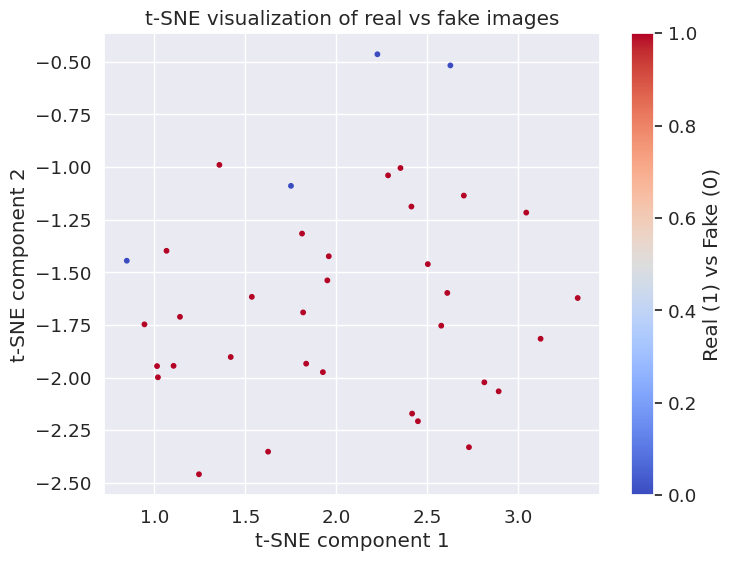

In [128]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Функция для преобразования изображений в векторное представление
def flatten_images(images):
    # Преобразуем изображения в одномерный вектор (формат [N, C, H, W] -> [N, C*H*W])
    return images.view(images.size(0), -1).cpu().detach().numpy()

# Функция для визуализации t-SNE
def visualize_tsne(real_images, fake_images):
    # Преобразуем изображения в векторы
    real_images_flat = flatten_images(real_images)
    fake_images_flat = flatten_images(fake_images)

    # Объединяем настоящие и фейковые изображения
    all_images = np.concatenate((real_images_flat, fake_images_flat), axis=0)

    # Применяем t-SNE для уменьшения размерности до 2D
    tsne = TSNE(n_components=2, random_state=42)
    all_images_tsne = tsne.fit_transform(all_images)

    # Создаем метки (реальные - 1, фейковые - 0)
    real_labels = np.ones(real_images_flat.shape[0])
    fake_labels = np.zeros(fake_images_flat.shape[0])
    all_labels = np.concatenate((real_labels, fake_labels), axis=0)

    # Визуализируем
    plt.figure(figsize=(8, 6))
    plt.scatter(all_images_tsne[:, 0], all_images_tsne[:, 1], c=all_labels, cmap='coolwarm', s=10)
    plt.title('t-SNE visualization of real vs fake images')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.colorbar(label='Real (1) vs Fake (0)')
    plt.show()

# Визуализируем распределения реальных и фейковых изображений
visualize_tsne(real_images, fake_images)


Прокомментируйте получившийся результат:

Видно, что реальные и фейковые изображения в основном группируются отдельно, что подтверждает высокую точность классификатора (0.9844). Это говорит о том, что модель генерации пока недостаточно качественно имитирует реальные данные. Чётких кластеров для реальных или фейковых данных не наблюдается, но фейковые изображения распределены более равномерно, тогда как реальные выглядят как более редкие точки. Некоторые точки реальных изображений всё же попадают в пространство, близкое к фейковым, что свидетельствует о возможном сходстве в некоторых аспектах. Это важно для дальнейшего анализа ошибок генерации.